---
title: 'Zonal statistics: mean elevation of brisbane suburbs'
date: '2025-04-15'
categories:
  - GIS
  - DEM
jupyter:
  kernelspec:
    display_name: Python (data-science)
    language: python
    name: data-science
---

As part of my geospatial analysis journey and the mapping of various things in Brisbane, in this notebook I will look at the digital elevation data of Brisbane suburbs.

I will tackle this as two sequential tasks:

1. Obtain the digital elevation model (DEM) for Brisbane.
2. Calculate the *mean elevation* of each Brisbane suburb.

# Obtaining the digital elevation model (DEM)
Digital elevation models (DEMs) are cartographic datasets containing topographic elevation information of natural/geological features (plains, valleys, mountains, etc.)
The data is composed of cells corresponding to each x/y location, where each cell contains the elevation information.

The python library `elevation` helps us easily download DEM data from global data providers (read [here](https://pypi.org/project/elevation/)). We can filter the datasets by latitude/longitude bounds (north, east, sothwest for any location on Earth.\

For the purpose of this notebook, we first need the geographic bounds of Brisbane. I have this in my PostGIS datbase, but I have also made it available [here](https://github.com/sandeepdhakal/ds-notebooks/blob/main/data/brisbane-suburbs.parq') as a *GeoParquet* file. Here, I will connect to the PostGIS database using `sqlalchemy` and `geopandas`.

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [13]:
user = "sandeep"
host = "localhost"
database = "brisbane"
driver = "postgresql+psycopg"
connection_str = f"{driver}://{user}@{host}/{database}"

engine = create_engine(connection_str)

sql = "SELECT * FROM suburbs"
suburbs = gpd.read_postgis(sql, engine, geom_col="geometry")

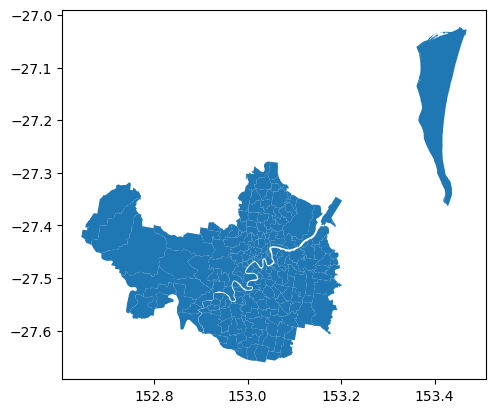

In [14]:
suburbs.plot()
plt.show()

Now that we have the suburb boundaries, we can get the overall bounds of Brisbane for use with `elevation`.

In [4]:
brisbane_bounds = suburbs.dissolve().bounds
brisbane_bounds

,minx,miny,maxx,maxy
0,152.644512,-27.660374,153.468495,-27.021952


Let's use these bounds to extract elevation data for Brisbane as a GeoTIFF file.

In [ ]:
# | output: false
import os

import elevation

output = os.getcwd() + "/../data/brisbane-elevation.tif"
elevation.clip(bounds=brisbane_bounds.iloc[0], output=output, product="SRTM1")

Now that we have the elevation model saved to disk, let's read it and plot it. *Note that below we read the first layer of data, since our DEM only contains one band*

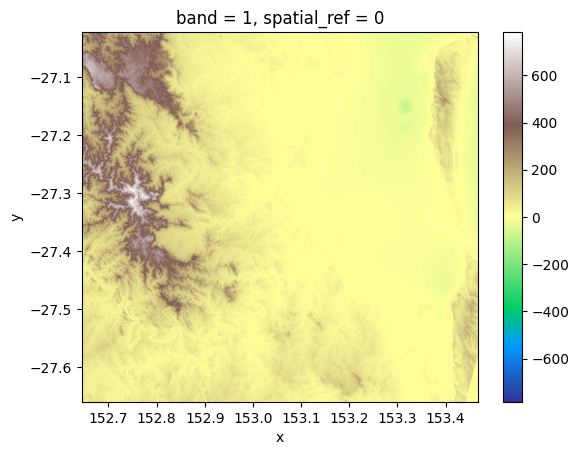

In [15]:
import matplotlib.pyplot as plt
import rioxarray as riox

dem = riox.open_rasterio(output).sel(band=1)
dem.plot(cmap="terrain")
plt.show()

## Clipping to Brisbane's geometry

Notice that since we only used the 4 geographical bounds to download the raster data, we will further need to mask it to Brisbane's geographic boundary. We can get the mask using the `dissolve` method from `geopandas`. Let's also filter by elevation above 0 meters, so we can focus on the land area.

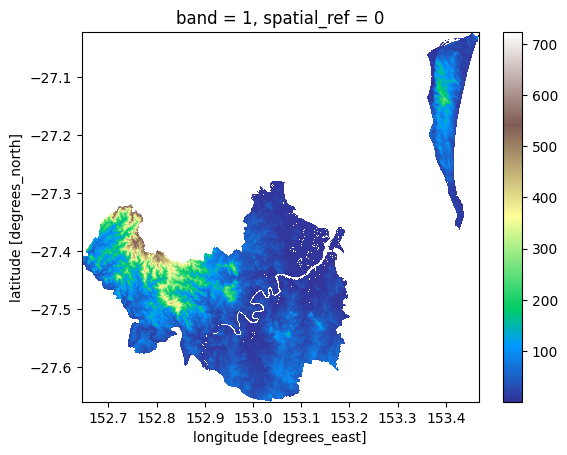

In [75]:
# shapely Polygon  to clip raster
# use shapely polygon in clip method of rioxarray object to clip raster
dem = dem.rio.clip(suburbs.dissolve().geometry)

# while plotting, lets only show elevation higher than 0 metres above sea-level.
dem.where(dem > 0).plot(cmap="terrain")

We can clearly see that most parts of Brisbane are low lying (under 100 metres above sea level) with north-western parts (such as England Creek, Lake Manchester, Mount Coot-tha, Enoggera Reservoir) with higher elevation.

We can also clip the data around the apparently low-lying parts to see the minute variations in elevation throughout the city, and the difference between the north-eastern and southern parts of the city.

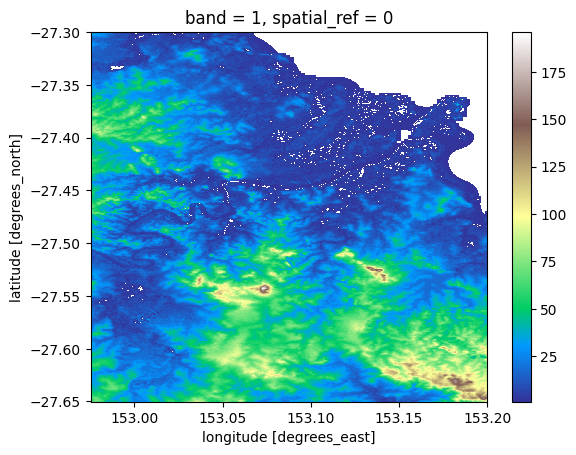

In [16]:
from shapely import Polygon

test_poly = [
    Polygon(((152.975, -27.3), (152.975, -27.65), (153.2, -27.65), (153.2, -27.3)))
]
clipped_dem = dem.rio.clip(test_poly)

fig, ax = plt.subplots()
clipped_dem.where(clipped_dem > 0).plot(cmap="terrain", ax=ax)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.show()

# Calculating mean elevation of suburbs
To calculate the mean elevation of each suburb, we will have to process each row (i.e. a suburb) in the suburbs database individually. We will apply the same concept of clipping/masking the individual polygons from the raster that we applied above.

In [17]:
import contextily as cx
import matplotlib.pyplot as plt


def get_mean_elevation(row, dem):
    # Extract geometry object
    geom = row["geometry"].__geo_interface__

    # Clip the surface to extract pixels within `geom`
    section = dem.rio.clip([geom], crs=suburbs.crs)

    # Calculate mean elevation
    elevation = float(section.where(section > 0).mean())
    return elevation


suburbs["mean_elevation"] = suburbs.apply(get_mean_elevation, dem=dem, axis=1)

Let's see what the data looks like now.

In [18]:
suburbs[["Name", "mean_elevation"]].head(5)

,Name,mean_elevation
0,Acacia Ridge,29.352489
1,Albion,12.686047
2,Alderley,41.318989
3,Algester,38.075565
4,Annerley,33.226566


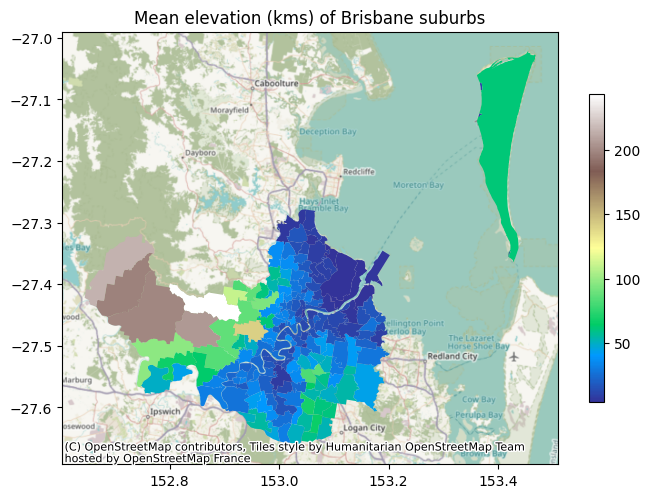

In [19]:
#| classes: preview-image

fig, ax = plt.subplots(figsize=(8, 8))
suburbs.plot(
    "mean_elevation",
    ax=ax,
    cmap="terrain",
    legend=True,
    legend_kwds=dict(shrink=0.5, location="right"),
)
cx.add_basemap(ax, crs=suburbs.crs)
ax.set_title("Mean elevation (kms) of Brisbane suburbs")
plt.show()

We can see that the mean elevation of most suburbs is less than 50 metres near the coast, and under 100 metres in most of the remaining suburbs. In fact only 10 (out of 194) suburbs have a mean elevation > 100 metres.

In [20]:
suburbs[suburbs["mean_elevation"] > 100][["Name", "mean_elevation"]]

,Name,mean_elevation
13,Banks Creek,197.255478
57,England Creek,214.656570
59,Enoggera Reservoir,243.230942
99,Lake Manchester,198.725540
117,Mount Coot-tha,141.496445
174,Upper Brookfield,205.690308
175,Upper Kedron,109.997452


Finally, we can also plot an interactive map using another framework such as `geoviews`.

In [21]:
suburbs.explore(
    column="mean_elevation", cmap="terrain", tooltip=["Name", "mean_elevation"]
)